# Features Engineering - Transformation

Before extracting features or building models, it's often beneficial to **transform raw price data** to make it more stable, normalized, or informative. These transformations are not indicators in themselves, but rather **tools that reshape the data**, allowing for better analysis, feature engineering, and model performance.

**Tips: These transformations can be especially useful when applied as preprocessing steps before building indicators, machine learning features, or trading signals.**

In [1]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## **Fisher Transform**

The `fisher_transform` function applies a mathematical transformation that converts **non-Gaussian price data into a distribution resembling a normal curve**.

This is particularly useful for **highlighting turning points**, because values tend to cluster near the center and **amplify at the extremes** (±2 or more), making overbought and oversold conditions easier to detect.

The formula is:

$$
x_t = \frac{2 \cdot \left( \text{median}_t - \min_t \right)}{\max_t - \min_t} - 1
\quad \Rightarrow \quad
\text{Fisher}_t = 0.5 \cdot \ln\left( \frac{1 + x_t}{1 - x_t} \right)
$$
- `x_t` is a normalized representation of the price at time `t`, scaled between -1 and 1.
- The Fisher Transform **amplifies edge behavior**, making it a good signal enhancer.


In [3]:
df["fisher"] = fe.transformation.fisher_transform(df=df, high_col="high", low_col="low", window_size=20)
df["fisher"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00   -0.668801
2016-12-30 08:00:00   -0.743482
2016-12-30 12:00:00   -1.010736
2016-12-30 16:00:00   -0.989038
2016-12-30 20:00:00   -1.199386
Name: fisher, Length: 1548, dtype: float64

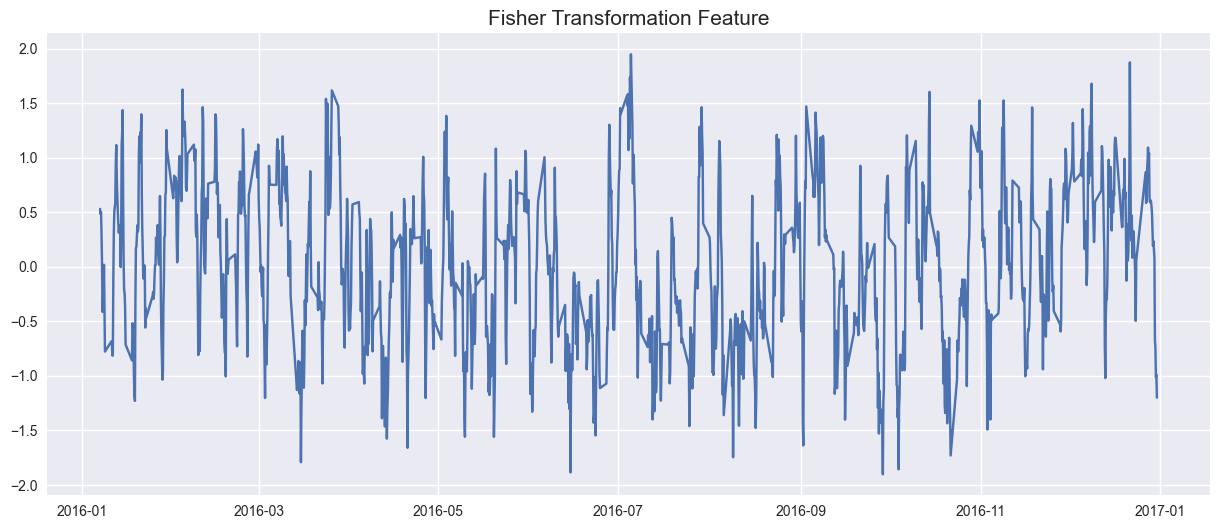

In [4]:
plt.figure(figsize=(15,6))
plt.plot(df["fisher"])
plt.title("Fisher Transformation Feature", size=15)
plt.show()

<br>

## **Savitzky-Golay Filter**

The `savgol_filter` function applies a **causal version of the Savitzky-Golay filter** to a time series.

This transformation fits a **polynomial of order `k`** over a **rolling window** of past values and evaluates the value of that polynomial at the **last point** of the window. It is widely used to **smooth noisy signals** while preserving **local structure** like peaks and inflection points.

<br>

**Warning "Causal vs Standard Savitzky-Golay"**

>This implementation differs from the classic `scipy.signal.savgol_filter`, which applies a **centered filter** that includes both past and >future values — causing **look-ahead bias** in real-time trading.

>Here, the filter is applied in a **rolling**, meaning it only uses **past observations** within the window.  
>This makes it **safe for backtesting and live usage**, while preserving most of the smoothing benefits of the standard version.


In [5]:
df["savgol"] = fe.transformation.savgol_filter(df=df, col="close", window_size=21, polyorder=2)
df["savgol"]

time
2016-01-04 00:00:00           NaN
2016-01-04 04:00:00           NaN
2016-01-04 08:00:00           NaN
2016-01-04 12:00:00           NaN
2016-01-04 16:00:00           NaN
                          ...    
2016-12-30 04:00:00    103.401992
2016-12-30 08:00:00    103.409066
2016-12-30 12:00:00    103.421625
2016-12-30 16:00:00    103.354999
2016-12-30 20:00:00    103.266365
Name: savgol, Length: 1548, dtype: float64

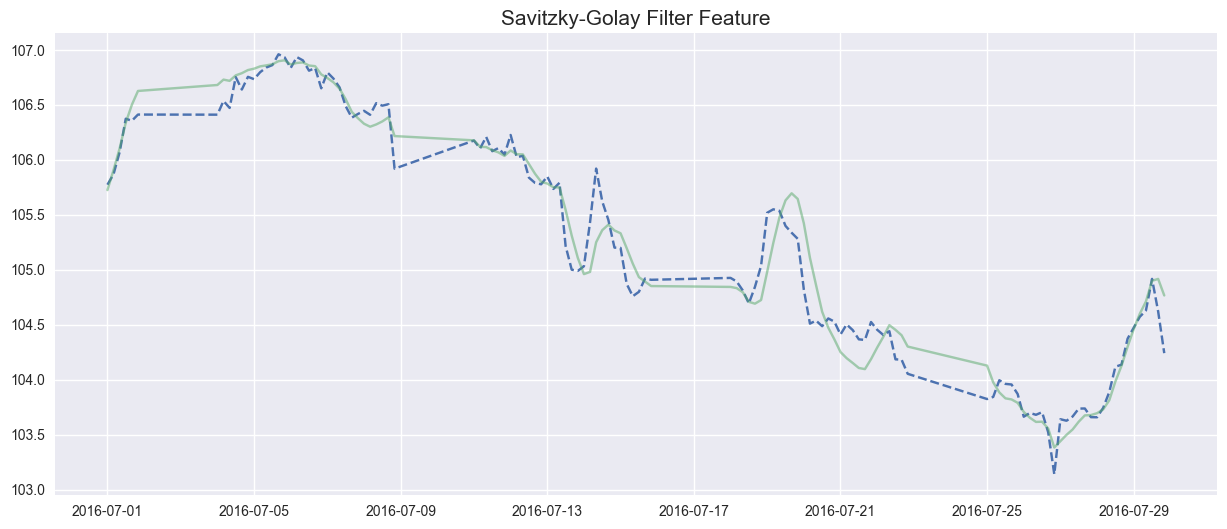

In [6]:
plt.figure(figsize=(15,6))
plt.plot(df["close"].loc["2016-07"], "--")
plt.plot(df["savgol"].loc["2016-07"], alpha=0.5)

plt.title("Savitzky-Golay Filter Feature", size=15)
plt.show()

<br>

## **Logit**

The `logit_transform` applies the **log-odds** mapping to a feature bounded in **(0, 1)**.
It stretches values near 0 and 1 (often the most informative) and maps (0, 1) to **(−∞, +∞)**.

$$
\operatorname{logit}(x)=\ln\!\left(\frac{x}{1-x}\right),\qquad x\in(0,1)
$$

In [7]:
# We create a bounded values between 0 and 1
_, df["adf_pvalue"] = fe.math.adf_test(df, col="close", window_size=80, lags=10, regression="ct")
df["adf_pvalue_logit"] = fe.transformation.logit_transform(df=df, col="adf_pvalue", eps=1e-6)
df["adf_pvalue_logit"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00   -1.847802
2016-12-30 08:00:00   -1.785827
2016-12-30 12:00:00   -1.901817
2016-12-30 16:00:00   -1.607037
2016-12-30 20:00:00   -1.286199
Name: adf_pvalue_logit, Length: 1548, dtype: float64

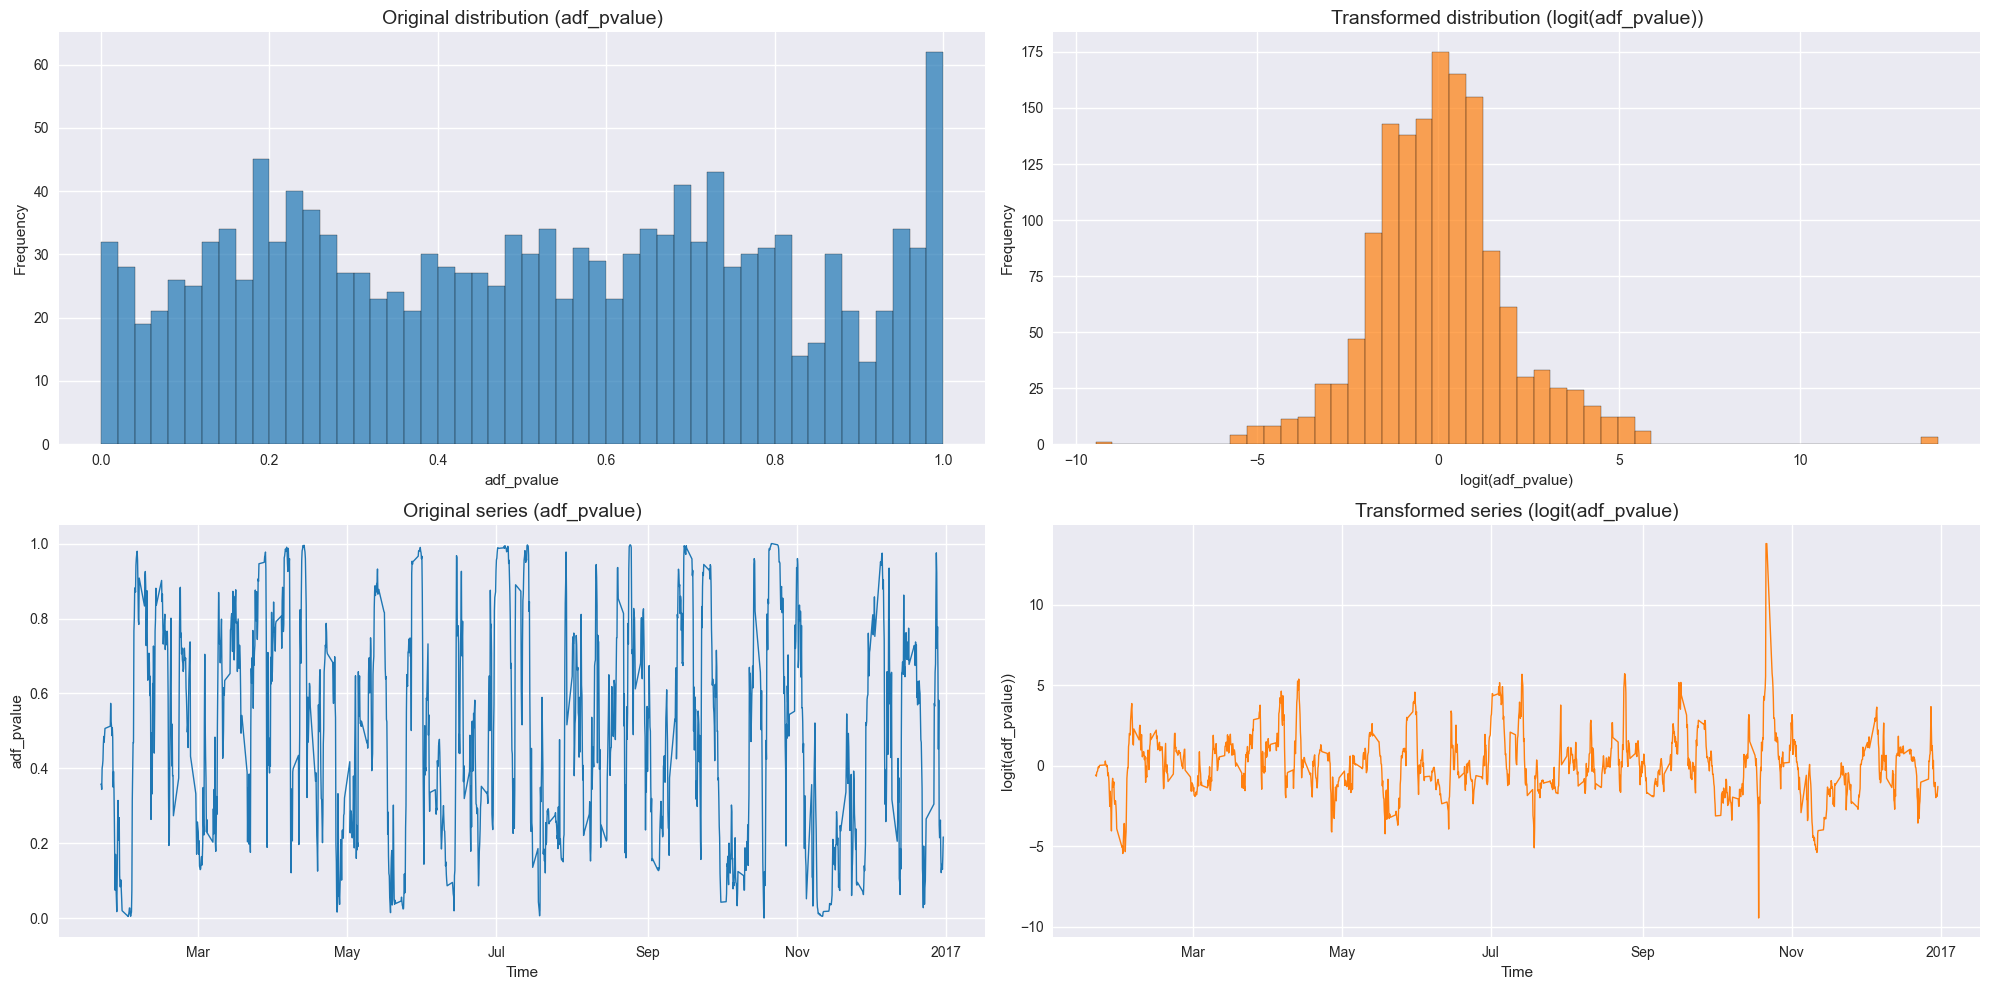

In [ ]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
import pandas as pd

# Set your column names here
orig_col = "adf_pvalue"
trans_col = "adf_pvalue_logit"

fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # no sharex/sharey on purpose

# --- Top-left: histogram (original) ---
axes[0, 0].hist(
    df[orig_col].dropna().to_numpy(), bins=50, alpha=0.7,
    color="tab:blue", edgecolor="black"
)
axes[0, 0].set_title(f"Original distribution ({orig_col})", fontsize=14)
axes[0, 0].set_xlabel(orig_col)
axes[0, 0].set_ylabel("Frequency")

# --- Top-right: histogram (transformed) ---
axes[0, 1].hist(
    df[trans_col].dropna().to_numpy(), bins=50, alpha=0.7,
    color="tab:orange", edgecolor="black"
)
axes[0, 1].set_title(f"Transformed distribution (logit({orig_col}))", fontsize=14)
axes[0, 1].set_xlabel(f"logit({orig_col})")
axes[0, 1].set_ylabel("Frequency")

# --- Bottom-left: time series (original) ---
axes[1, 0].plot(df.index, df[orig_col], linewidth=1.0, color="tab:blue")
axes[1, 0].set_title(f"Original series ({orig_col})", fontsize=14)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel(orig_col)

# --- Bottom-right: time series (transformed) ---
axes[1, 1].plot(df.index, df[trans_col], linewidth=1.0, color="tab:orange")
axes[1, 1].set_title(f"Transformed series (logit({orig_col})", fontsize=14)
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel(f"logit({orig_col}))")

# Nice date formatting for bottom row if index is datetime-like
if pd.api.types.is_datetime64_any_dtype(df.index):
    locator = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)
    for ax in (axes[1, 0], axes[1, 1]):
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

<br>

## **Negative Logarithm**

The `neg_log_transform` applies the **negative natural logarithm** to values in **(0, 1]**.
It highlights small values (close to 0) by expanding them, while values closer to 1 remain compressed.
This transformation is widely used in **p-value analysis** or whenever rare events need to be emphasized.

$$
f(x) = -\ln(x), \qquad x \in (0,1]
$$

In [7]:
# We create a bounded values between 0 and 1
_, df["adf_pvalue"] = fe.math.adf_test(df, col="close", window_size=80, lags=10, regression="ct")
df["adf_pvalue_neglog"] = fe.transformation.neg_log_transform(df=df, col="adf_pvalue", eps=1e-6)
df["adf_pvalue_neglog"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00    1.994136
2016-12-30 08:00:00    1.940827
2016-12-30 12:00:00    2.040967
2016-12-30 16:00:00    1.789759
2016-12-30 20:00:00    1.530179
Name: adf_pvalue_neglog, Length: 1548, dtype: float64

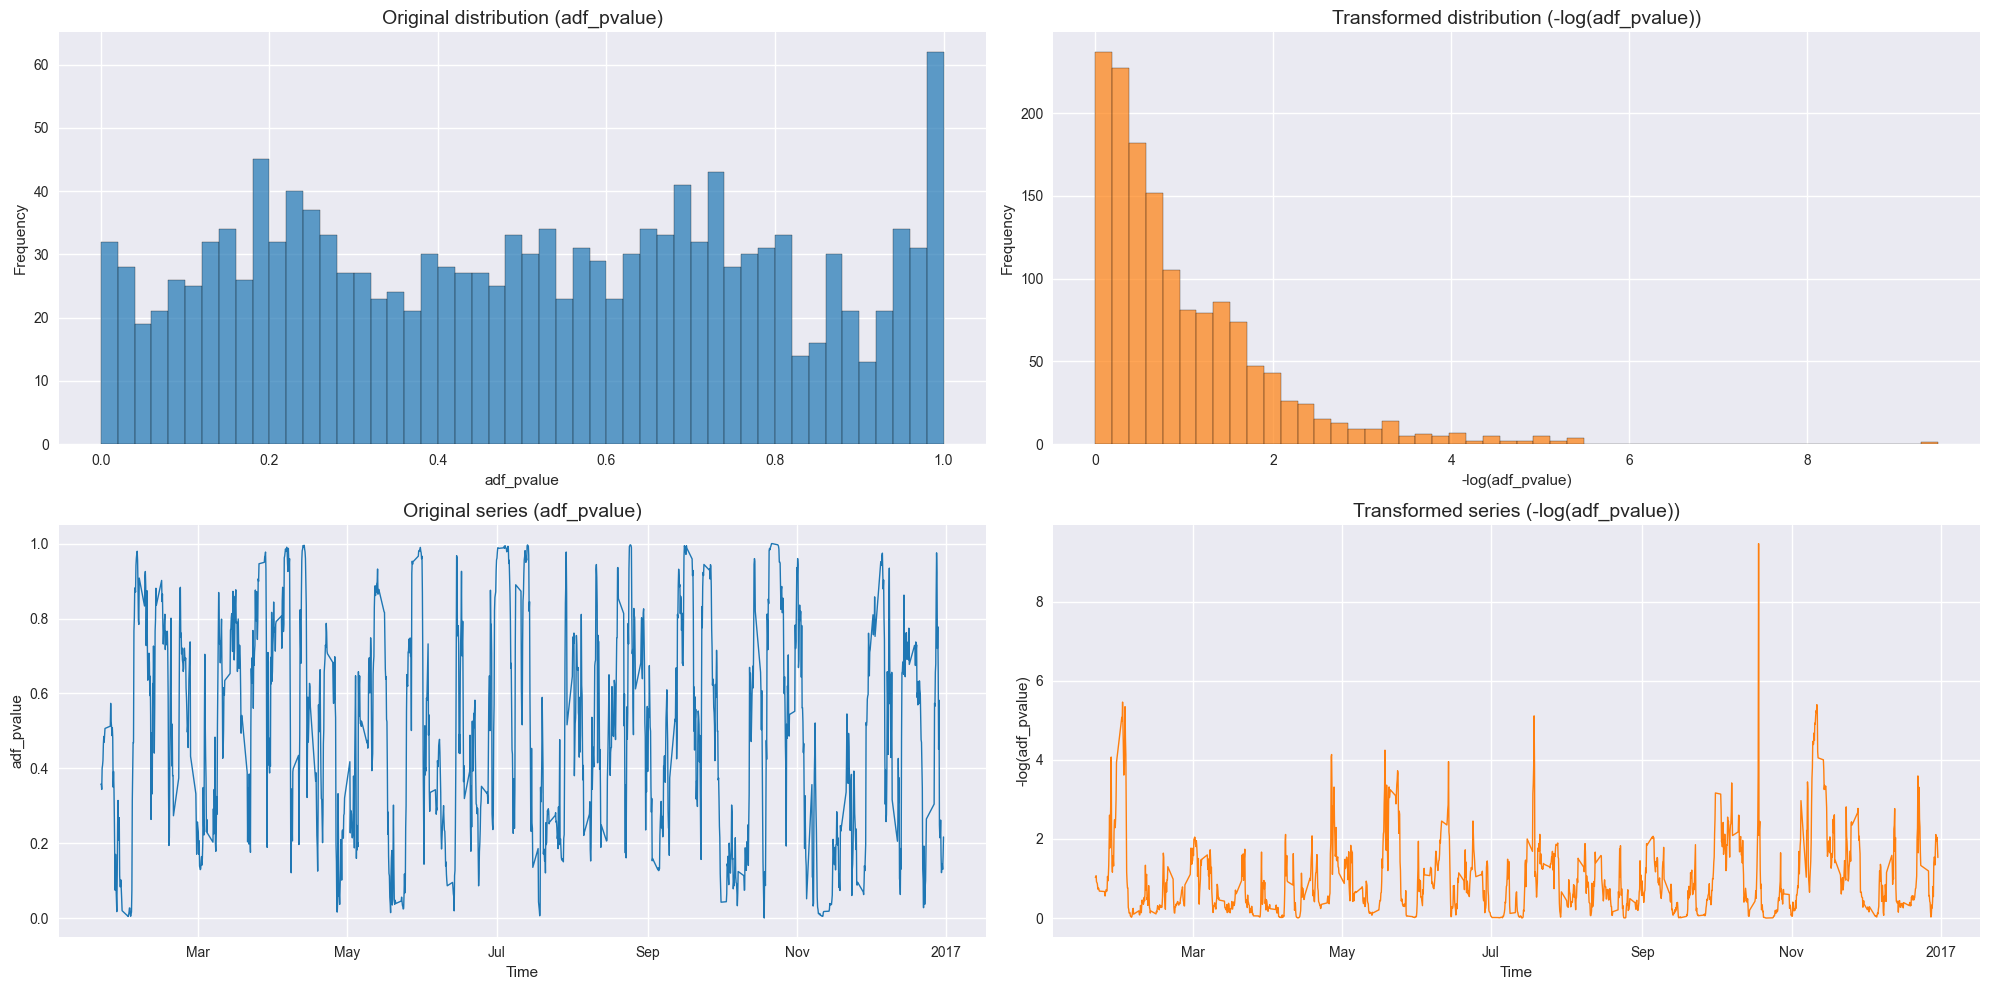

In [8]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
import pandas as pd

# Set your column names here
orig_col = "adf_pvalue"
trans_col = "adf_pvalue_neglog"   # if yours is "abs_auto_non_leg", change this

fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # no sharex/sharey on purpose

# --- Top-left: histogram (original) ---
axes[0, 0].hist(
    df[orig_col].dropna().to_numpy(), bins=50, alpha=0.7,
    color="tab:blue", edgecolor="black"
)
axes[0, 0].set_title(f"Original distribution ({orig_col})", fontsize=14)
axes[0, 0].set_xlabel(orig_col)
axes[0, 0].set_ylabel("Frequency")

# --- Top-right: histogram (transformed) ---
axes[0, 1].hist(
    df[trans_col].dropna().to_numpy(), bins=50, alpha=0.7,
    color="tab:orange", edgecolor="black"
)
axes[0, 1].set_title(f"Transformed distribution (-log({orig_col}))", fontsize=14)
axes[0, 1].set_xlabel(f"-log({orig_col})")
axes[0, 1].set_ylabel("Frequency")

# --- Bottom-left: time series (original) ---
axes[1, 0].plot(df.index, df[orig_col], linewidth=1.0, color="tab:blue")
axes[1, 0].set_title(f"Original series ({orig_col})", fontsize=14)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel(orig_col)

# --- Bottom-right: time series (transformed) ---
axes[1, 1].plot(df.index, df[trans_col], linewidth=1.0, color="tab:orange")
axes[1, 1].set_title(f"Transformed series (-log({orig_col}))", fontsize=14)
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel(f"-log({orig_col})")

# Nice date formatting for bottom row if index is datetime-like
if pd.api.types.is_datetime64_any_dtype(df.index):
    locator = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)
    for ax in (axes[1, 0], axes[1, 1]):
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

<br>

## **Causal Fourier Reconstruction**

The `fourier_transform` function applies a **Discrete Fourier Transform (DFT)** on a **rolling window** and reconstructs the signal while keeping only a subset of frequencies.
At each step, it returns **the last reconstructed point** (causal), yielding a time-aligned feature you can use directly in backtests or live trading.

Typical uses:
- **Low-pass filtering** (`mode="lowpass"`) to smooth volatility or extract long-term trend
- **Top-K dominant cycles** (`mode="topk"`) to capture the strongest periodic components in the market
- Noise reduction by discarding high-frequency oscillations

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
df["ctc_vol"] = fe.volatility.close_to_close_volatility(df=df, close_col="close", window_size=30)
df["ctc_vol_fft"] = fe.transformation.fourier_transform(df=df, col="ctc_vol", window_size=256, mode="lowpass", fmax_ratio=0.03, keep_dc=True)

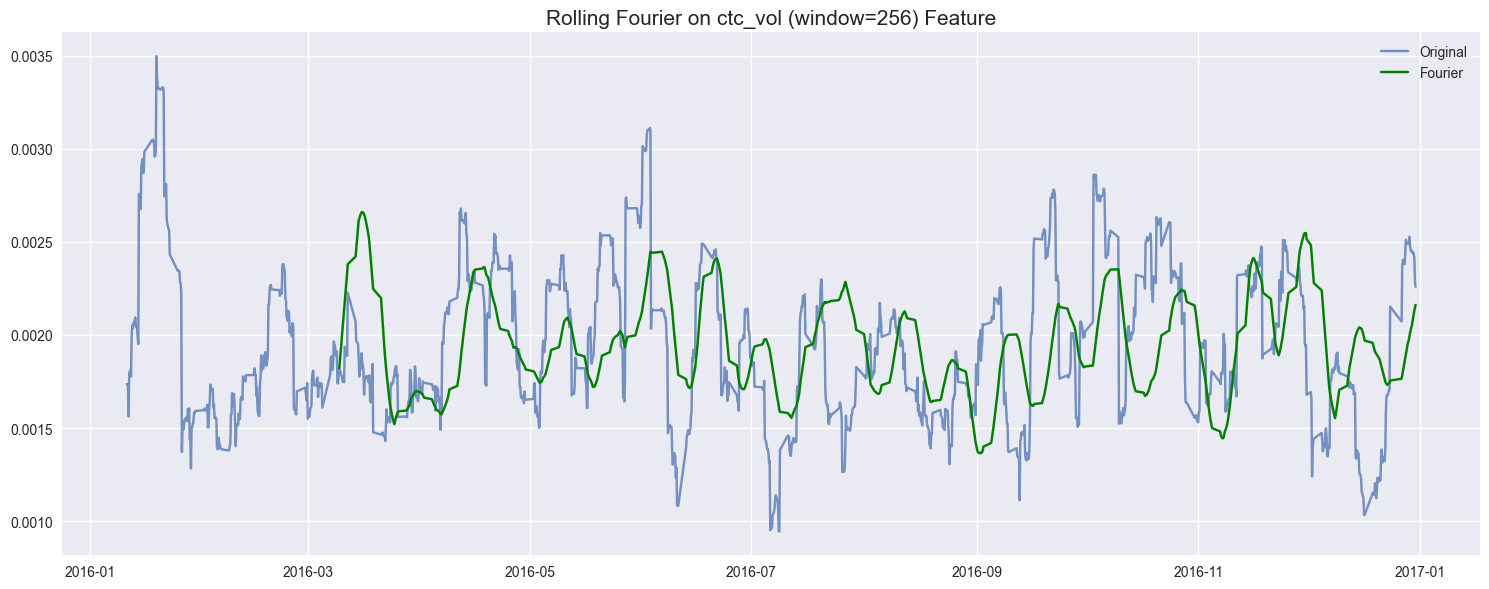

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df["ctc_vol"], label="Original", alpha=0.75)
plt.plot(df["ctc_vol_fft"], label="Fourier", color="green")
plt.title("Rolling Fourier on ctc_vol (window=256) Feature", fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

<br>

## **Causal Wavelet Reconstruction**

The `wavelet_transform` function applies a **Discrete Wavelet Transform (DWT)** on a **rolling window** and reconstructs the window while keeping only selected frequency bands.
At each step it returns **the last reconstructed point** (causal), yielding a time-aligned feature you can use directly (e.g., smoothed trend or high-frequency component).

Typical uses:
- **Low-pass trend** (`keep="approx"`) for denoising and regime tracking
- **High-frequency component** (`keep="details"`) to capture micro-volatility/noise
- **Full reconstruction** (`keep="all"`) as a reference or for residual analysis (original − recon)

In [10]:
df["ctc_vol"] = fe.volatility.close_to_close_volatility(df=df, close_col="close", window_size=30)
df["ctc_vol_wavelet"] = fe.transformation.wavelet_transform(df=df, col="ctc_vol", window_size=256, wavelet="sym2", level=8, keep="approx")

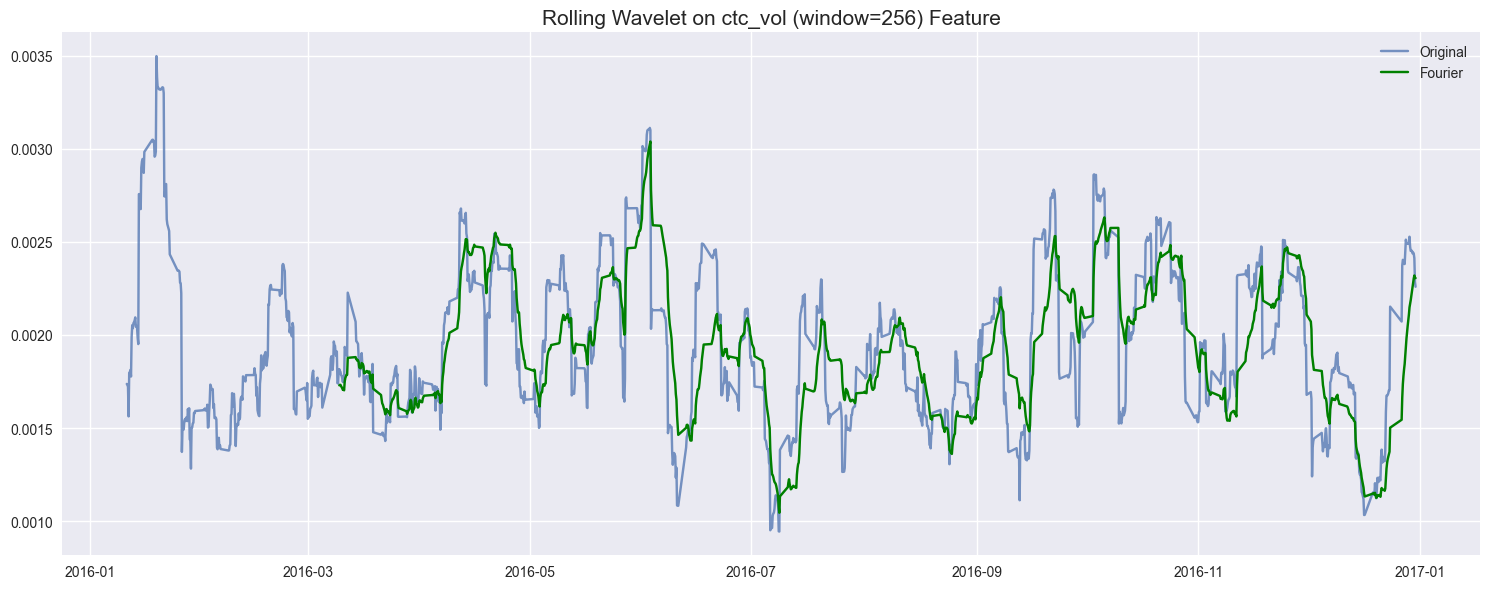

In [14]:
plt.figure(figsize=(15,6))
plt.plot(df["ctc_vol"], label="Original", alpha=0.75)
plt.plot(df["ctc_vol_wavelet"], label="Fourier", color="green")
plt.title("Rolling Wavelet on ctc_vol (window=256) Feature", fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

<br>

## **Median Moving Average**

The `mma` function computes the **Median Moving Average (MMA)** over a rolling window.
Unlike the Simple Moving Average (SMA), which uses the mean, the MMA uses the **median**, making it **more robust to outliers and sudden price spikes**.


In [3]:
df["close_smoothed"] = fe.transformation.mma(df=df, col="close", window_size=3)
df["close_smoothed"]

time
2016-01-04 00:00:00           NaN
2016-01-04 04:00:00           NaN
2016-01-04 08:00:00    105.232289
2016-01-04 12:00:00    105.149357
2016-01-04 16:00:00    105.014347
                          ...    
2016-12-30 04:00:00    103.622535
2016-12-30 08:00:00    103.616731
2016-12-30 12:00:00    103.564574
2016-12-30 16:00:00    103.515847
2016-12-30 20:00:00    103.422193
Name: close_smoothed, Length: 1548, dtype: float64

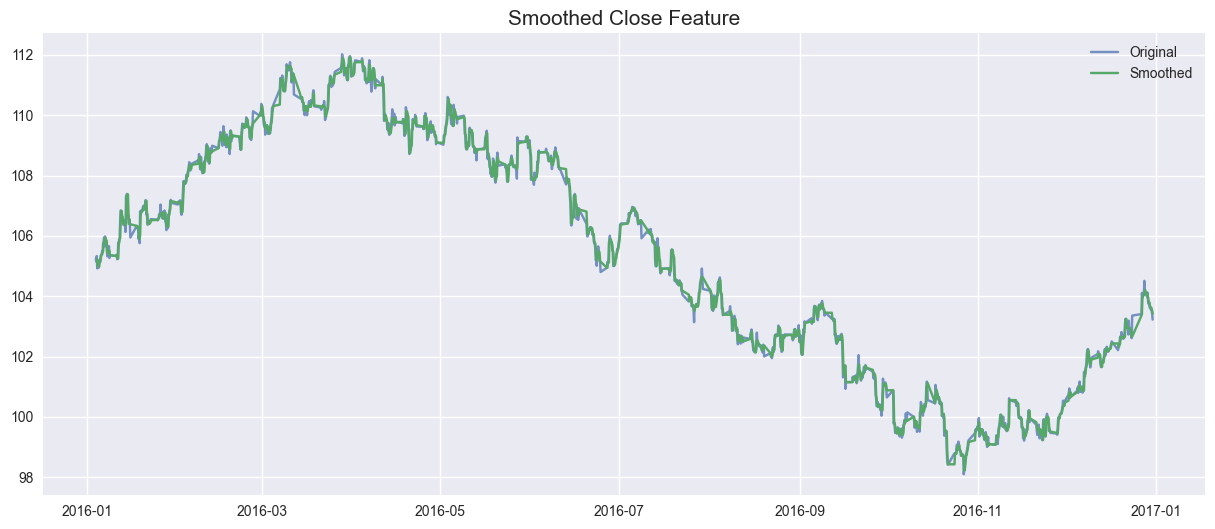

In [5]:
plt.figure(figsize=(15,6))
plt.plot(df["close"], label="Original", alpha=0.75)
plt.plot(df["close_smoothed"], label="Smoothed")
plt.title("Smoothed Close Feature", size=15)
plt.legend()
plt.show()